In [1]:
import numpy as np
import torch
from tqdm import tqdm
from skimage.metrics import structural_similarity as ssim
from torch.autograd import Variable
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import fashion_mnist
from time import time
import sklearn.preprocessing
import numpy as np
import robust_onlinehd
from GenAttack import GenAttack

In [2]:
scaler = sklearn.preprocessing.Normalizer()

In [3]:
torch.manual_seed(33)

In [4]:

# loads simple mnist dataset
def load():  
    (x, y), (x_test, y_test) = fashion_mnist.load_data()

    # changes data to pytorch's tensors
    x = torch.from_numpy(x).float()   
    y = torch.from_numpy(y).long().squeeze()
    x_test = torch.from_numpy(x_test).float()
    y_test = torch.from_numpy(y_test).long().squeeze()
    
    if len(x.shape) == 3:
        x = x.unsqueeze(3)
        x_test = x_test.unsqueeze(3)

    return x, x_test, y, y_test


print('Loading...')
x, x_test, y, y_test = load()

Loading...


<ipython-input-4-84a179f8522e>:6: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /opt/conda/conda-bld/pytorch_1607370172916/work/torch/csrc/utils/tensor_numpy.cpp:141.)
  x = torch.from_numpy(x).float()


In [5]:
#criterias = [(0, 100, 0), (100, 150, 125), (150, 200, 175), (200, 256, 255)]
#criterias = [(0, 50, 0), (50, 100, 75), (100, 125, 124), (125, 150, 149), (150, 175, 174), (175, 200, 199), (200, 225, 224), (225, 256, 255)]
#criterias = []
#kernel_size = 3
kernel_size = 1
classes = y.unique().size(0)
features = x.size(1) * x.size(2)
model = robust_onlinehd.OnlineHD(kernel_size, scaler, classes, features, dim = 10000)

In [6]:
model.set_criterias(x, 10)


if torch.cuda.is_available():
    #x = x.cuda()
    #y = y.cuda()
    #x_test = x_test.cuda()
    #y_test = y_test.cuda()
    model = model.to('cuda')
    print('Using GPU!')

print('Training...')
t = time()

model = model.fit(x, y, bootstrap=.3, lr=0.095, epochs=300, batch_size=8196)
t = time() - t

print('Validating...')
yhat = model(x).cpu()
yhat_test = model(x_test).cpu()
acc = (y == yhat).float().mean()
acc_test = (y_test == yhat_test).float().mean()
print(f'{acc = :6f}')
print(f'{acc_test = :6f}')
print(f'{t = :6f}')


In [ ]:
preds = model(x_test).cpu().numpy()
#preds = model(x).cpu().numpy()

In [ ]:
targets = torch.randint(0, 10, preds.shape)
for i in tqdm(range(len(preds))):
    while targets[i] == preds[i]:
        targets[i] = torch.randint(0,10, (1,)).item()

100%|██████████| 10000/10000 [00:00<00:00, 51617.76it/s]


In [ ]:
unif = torch.ones(targets.shape[0])
while True:
    indices = unif.multinomial(100)
    for idx in indices:
        if targets[idx] == y_test[idx]:
            break
    if idx == indices[-1] and targets[idx] != y_test[idx]:
        break
    else:
        indices = unif.multinomial(100)

In [ ]:
attacker = GenAttack(model, classes, 28 * 28, scaler, 0.6, 'cuda')
N = 8                          # size of population to evolve
G = 5000                        # number of generations to evolve through
p = torch.FloatTensor([0.9])   # the parameter for Bernoulli distribution used in mutation
alpha = torch.FloatTensor([1.0]) # the parameter controlling mutation amount (step-size in the original paper)
delta = torch.FloatTensor([0.9]) # the parametr controlling mutation amount (norm threshold in the original paper)

In [ ]:
pops = []
results = []

In [ ]:
t = time()
for i in tqdm(indices):
    temp = attacker.attack(x_test[i], targets[i], delta, alpha, p, N, G)
    pops.append(temp[0].numpy())
    results.append(temp[1])
t = time() - t

print(f'{t = :6f}')

  1%|          | 1/100 [04:46<7:52:48, 286.55s/it]

All 5000 generations failed.


  2%|▏         | 2/100 [09:15<7:31:33, 276.47s/it]

All 5000 generations failed.


  3%|▎         | 3/100 [13:47<7:23:20, 274.23s/it]

All 5000 generations failed.


  4%|▍         | 4/100 [18:13<7:13:25, 270.89s/it]

All 5000 generations failed.


  5%|▌         | 5/100 [22:44<7:08:48, 270.82s/it]

All 5000 generations failed.


  6%|▌         | 6/100 [27:10<7:02:07, 269.44s/it]

All 5000 generations failed.


  7%|▋         | 7/100 [31:42<6:58:45, 270.17s/it]

All 5000 generations failed.


  8%|▊         | 8/100 [36:14<6:55:01, 270.67s/it]

All 5000 generations failed.


  9%|▉         | 9/100 [40:43<6:50:02, 270.36s/it]

All 5000 generations failed.


 10%|█         | 10/100 [45:10<6:43:52, 269.25s/it]

All 5000 generations failed.


 11%|█         | 11/100 [49:40<6:39:51, 269.56s/it]

All 5000 generations failed.


 12%|█▏        | 12/100 [54:09<6:35:05, 269.39s/it]

All 5000 generations failed.


 13%|█▎        | 13/100 [58:36<6:29:30, 268.63s/it]

All 5000 generations failed.


 14%|█▍        | 14/100 [58:58<4:37:57, 193.93s/it]

Attack Success at generation 389


 15%|█▌        | 15/100 [1:03:15<5:01:43, 212.99s/it]

All 5000 generations failed.


 16%|█▌        | 16/100 [1:07:43<5:21:25, 229.59s/it]

All 5000 generations failed.


 17%|█▋        | 17/100 [1:12:11<5:33:46, 241.28s/it]

All 5000 generations failed.


 18%|█▊        | 18/100 [1:16:41<5:41:31, 249.89s/it]

All 5000 generations failed.


 19%|█▉        | 19/100 [1:21:04<5:42:34, 253.76s/it]

All 5000 generations failed.


 20%|██        | 20/100 [1:25:35<5:45:20, 259.01s/it]

All 5000 generations failed.


 21%|██        | 21/100 [1:30:00<5:43:10, 260.64s/it]

All 5000 generations failed.


 22%|██▏       | 22/100 [1:34:29<5:42:02, 263.11s/it]

All 5000 generations failed.


 23%|██▎       | 23/100 [1:38:59<5:40:35, 265.39s/it]

All 5000 generations failed.


 24%|██▍       | 24/100 [1:43:28<5:37:27, 266.41s/it]

All 5000 generations failed.


 25%|██▌       | 25/100 [1:47:59<5:34:36, 267.69s/it]

All 5000 generations failed.


 26%|██▌       | 26/100 [1:52:22<5:28:26, 266.30s/it]

All 5000 generations failed.


 27%|██▋       | 27/100 [1:56:48<5:23:52, 266.19s/it]

All 5000 generations failed.


 28%|██▊       | 28/100 [2:01:04<5:15:56, 263.29s/it]

All 5000 generations failed.


 29%|██▉       | 29/100 [2:05:34<5:13:58, 265.34s/it]

All 5000 generations failed.


 30%|███       | 30/100 [2:09:58<5:09:00, 264.87s/it]

All 5000 generations failed.


 31%|███       | 31/100 [2:14:19<5:03:02, 263.51s/it]

All 5000 generations failed.


 32%|███▏      | 32/100 [2:18:41<4:58:24, 263.31s/it]

All 5000 generations failed.


 33%|███▎      | 33/100 [2:23:12<4:56:26, 265.46s/it]

All 5000 generations failed.
All candidates died at generation 0
Target =  tensor(3, device='cuda:0')


 35%|███▌      | 35/100 [2:27:42<3:42:28, 205.37s/it]

All 5000 generations failed.


 36%|███▌      | 36/100 [2:32:13<3:56:22, 221.61s/it]

All 5000 generations failed.


 37%|███▋      | 37/100 [2:36:44<4:06:11, 234.48s/it]

All 5000 generations failed.


 38%|███▊      | 38/100 [2:41:14<4:12:15, 244.11s/it]

All 5000 generations failed.


 39%|███▉      | 39/100 [2:45:45<4:15:59, 251.79s/it]

All 5000 generations failed.


 40%|████      | 40/100 [2:50:13<4:16:16, 256.27s/it]

All 5000 generations failed.


 41%|████      | 41/100 [2:54:41<4:15:18, 259.64s/it]

All 5000 generations failed.


 42%|████▏     | 42/100 [2:59:08<4:12:59, 261.72s/it]

All 5000 generations failed.


 43%|████▎     | 43/100 [2:59:15<2:57:15, 186.59s/it]

Attack Success at generation 128


 44%|████▍     | 44/100 [3:03:44<3:17:05, 211.17s/it]

All 5000 generations failed.


 45%|████▌     | 45/100 [3:08:11<3:28:45, 227.74s/it]

All 5000 generations failed.


 46%|████▌     | 46/100 [3:12:40<3:36:04, 240.08s/it]

All 5000 generations failed.


 47%|████▋     | 47/100 [3:17:12<3:40:26, 249.55s/it]

All 5000 generations failed.


 48%|████▊     | 48/100 [3:21:37<3:40:14, 254.13s/it]

All 5000 generations failed.


 49%|████▉     | 49/100 [3:26:06<3:39:45, 258.54s/it]

All 5000 generations failed.


 50%|█████     | 50/100 [3:30:34<3:37:48, 261.36s/it]

All 5000 generations failed.


 51%|█████     | 51/100 [3:35:07<3:36:27, 265.05s/it]

All 5000 generations failed.


 52%|█████▏    | 52/100 [3:39:34<3:32:33, 265.69s/it]

All 5000 generations failed.


 53%|█████▎    | 53/100 [3:43:56<3:27:08, 264.43s/it]

All 5000 generations failed.


 54%|█████▍    | 54/100 [3:48:24<3:23:36, 265.57s/it]

All 5000 generations failed.


 55%|█████▌    | 55/100 [3:52:54<3:20:12, 266.95s/it]

All 5000 generations failed.


 56%|█████▌    | 56/100 [3:57:26<3:16:49, 268.39s/it]

All 5000 generations failed.


 57%|█████▋    | 57/100 [4:01:55<3:12:22, 268.42s/it]

All 5000 generations failed.


 58%|█████▊    | 58/100 [4:06:16<3:06:25, 266.33s/it]

All 5000 generations failed.


 59%|█████▉    | 59/100 [4:10:43<3:02:11, 266.62s/it]

All 5000 generations failed.


 60%|██████    | 60/100 [4:15:08<2:57:26, 266.17s/it]

All 5000 generations failed.


 61%|██████    | 61/100 [4:19:39<2:53:47, 267.36s/it]

All 5000 generations failed.


 62%|██████▏   | 62/100 [4:24:07<2:49:36, 267.81s/it]

All 5000 generations failed.


 63%|██████▎   | 63/100 [4:28:35<2:45:03, 267.66s/it]

All 5000 generations failed.


 64%|██████▍   | 64/100 [4:32:55<2:39:20, 265.58s/it]

All 5000 generations failed.


 65%|██████▌   | 65/100 [4:37:30<2:36:33, 268.39s/it]

All 5000 generations failed.


 66%|██████▌   | 66/100 [4:37:51<1:50:03, 194.21s/it]

Attack Success at generation 385


 67%|██████▋   | 67/100 [4:42:20<1:59:00, 216.38s/it]

All 5000 generations failed.


 68%|██████▊   | 68/100 [4:46:53<2:04:27, 233.36s/it]

All 5000 generations failed.


 69%|██████▉   | 69/100 [4:51:23<2:06:16, 244.40s/it]

All 5000 generations failed.


 70%|███████   | 70/100 [4:55:54<2:06:17, 252.58s/it]

All 5000 generations failed.


 71%|███████   | 71/100 [5:00:27<2:04:55, 258.48s/it]

All 5000 generations failed.


 72%|███████▏  | 72/100 [5:04:55<2:02:03, 261.56s/it]

All 5000 generations failed.


 73%|███████▎  | 73/100 [5:09:26<1:58:56, 264.30s/it]

All 5000 generations failed.


 74%|███████▍  | 74/100 [5:13:58<1:55:27, 266.45s/it]

All 5000 generations failed.


 75%|███████▌  | 75/100 [5:18:23<1:50:56, 266.25s/it]

All 5000 generations failed.


 76%|███████▌  | 76/100 [5:22:53<1:46:53, 267.21s/it]

All 5000 generations failed.


 77%|███████▋  | 77/100 [5:27:22<1:42:36, 267.68s/it]

All 5000 generations failed.


 78%|███████▊  | 78/100 [5:31:52<1:38:30, 268.64s/it]

All 5000 generations failed.


 79%|███████▉  | 79/100 [5:36:18<1:33:40, 267.62s/it]

All 5000 generations failed.


 80%|████████  | 80/100 [5:40:33<1:27:55, 263.78s/it]

All 5000 generations failed.


 81%|████████  | 81/100 [5:44:59<1:23:45, 264.50s/it]

All 5000 generations failed.


 82%|████████▏ | 82/100 [5:49:28<1:19:47, 265.97s/it]

All 5000 generations failed.


 83%|████████▎ | 83/100 [5:53:56<1:15:32, 266.61s/it]

All 5000 generations failed.


 84%|████████▍ | 84/100 [5:58:00<1:09:14, 259.69s/it]

All 5000 generations failed.


 85%|████████▌ | 85/100 [6:00:16<55:39, 222.65s/it]  

All 5000 generations failed.


 86%|████████▌ | 86/100 [6:02:34<46:00, 197.19s/it]

All 5000 generations failed.


 87%|████████▋ | 87/100 [6:04:52<38:54, 179.56s/it]

All 5000 generations failed.


 88%|████████▊ | 88/100 [6:07:08<33:18, 166.55s/it]

All 5000 generations failed.


 89%|████████▉ | 89/100 [6:08:55<27:15, 148.72s/it]

All 5000 generations failed.


 90%|█████████ | 90/100 [6:09:59<20:31, 123.11s/it]

All 5000 generations failed.


 91%|█████████ | 91/100 [6:11:02<15:46, 105.17s/it]

All 5000 generations failed.


 92%|█████████▏| 92/100 [6:12:05<12:20, 92.54s/it] 

All 5000 generations failed.


 93%|█████████▎| 93/100 [6:13:11<09:52, 84.64s/it]

All 5000 generations failed.


 94%|█████████▍| 94/100 [6:14:15<07:49, 78.22s/it]

All 5000 generations failed.


 95%|█████████▌| 95/100 [6:15:18<06:08, 73.79s/it]

All 5000 generations failed.


 96%|█████████▌| 96/100 [6:16:21<04:42, 70.63s/it]

All 5000 generations failed.


 97%|█████████▋| 97/100 [6:17:25<03:25, 68.40s/it]

All 5000 generations failed.


 98%|█████████▊| 98/100 [6:18:29<02:14, 67.20s/it]

All 5000 generations failed.


 99%|█████████▉| 99/100 [6:19:38<01:07, 67.82s/it]

All 5000 generations failed.


100%|██████████| 100/100 [6:20:42<00:00, 228.42s/it]

All 5000 generations failed.
t = 22842.247137


In [ ]:
pops = np.array(pops)

In [ ]:
sample_preds = preds[indices]

In [ ]:
new_preds = []
for i in range(100):
    new_preds.append(model(torch.tensor(pops[i])).cpu().numpy())

In [ ]:
success = 0
success_idx = []
for i in range(100):
    if targets[indices[i]].item() in new_preds[i]:
        success_idx.append((indices[i].item(), (i, np.where(new_preds[i] == targets[indices[i]].item())[0][0])))
        success += 1
print(success)

3


In [ ]:
cache = {
    'indices' : indices,
    'sample_preds' : sample_preds,
    'pops' : np.array(pops),
    'hyper_parameter' : [N, G, p, alpha, delta],
    'success_idx' : success_idx,
    'model' : model, 
    'scaler' : model.scaler,
    'targets' : targets,
    'results' : results
}

In [ ]:
torch.save(cache, 'robust_onlinehd_fashion_mnist.pt')

In [ ]:
model(torch.tensor(pops[0]))

tensor([6, 6, 6, 6, 6, 6, 6, 6], device='cuda:0')

In [ ]:
labels = {
    0 : 'T-shirt/top',
    1 : 'Trouser',
    2 : 'Pullover',
    3 : 'Dress',
    4 : 'Coat',
    5 : 'Sandal',
    6 : 'Shirt',
    7 : 'Sneaker',
    8 : 'Bag',
    9 : 'Ankle boot'
}

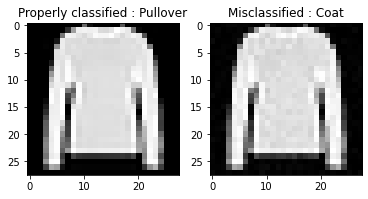

In [ ]:
origin_idx, (new_idx, new_idx_idx) = success_idx[torch.randint(0, len(success_idx), (1,)).item()]

f, axes = plt.subplots(1, 2)
axes[0].imshow(x_test[origin_idx], cmap=plt.gray())
_ = axes[0].set_title('Properly classified : %s' % labels[sample_preds[new_idx].item()])
axes[1].imshow(pops[new_idx][new_idx_idx].astype(np.int32))
_ = axes[1].set_title('Misclassified : %s' % labels[new_preds[new_idx][new_idx_idx]])